### Meta Labeling I

<center><img src = "https://hudsonthames.org/wp-content/uploads/2021/11/meta_labeling.png" alt="My Image"></center>

Meta Labeling은 Marcos Lopez de Prado(2018)가 저서 Advances in Financial Machine Learning에서 제안한 모형으로, labeling문제에 직면한 금융 머신러닝 프로젝트에 적절한 방법을 제시한다. 다음과 같은 논리로 이뤄진다

1. Feature 준비 : 자산에 대한 가격 데이터, technical feature등을 포함한 feature matrix를 준비한다
2. Primary Model : 자산의 가격이 상승할지, 하강할지 판단하는 모형이다. 여기에는 자신만의 판단 기준을 내세울 수 있으며, 때로는 애널리스트의 판단이 될 수 있다
3. Secondary Model : Primary Model에서 나온 정보를 가지고 거래를 집행할지, 하지 않을지를 판단하는 모형이다. 거래 집행 유무만 판단하므로 이진 분류 문제가 된다

오늘은 technical feature를 이용해 간단한 이동평균 매수매도 전략을 Primary Model로 제작한 후, Secondary Model을 이용해 매매 의사결정 모형을 만들 것이다

#### 1. Data Import

아래의 library를 활용해 Apple의 가격 시계열을 불러오자. 한국은 공매도 집행이 금지되었으므로 고려하지 않는다. 기간은 2000년 1월 1일부터 11월 15일까지로 지정한다. 시계열이므로 정상성을 위해 로그 차분을 진행한다

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

start_date = '2000-01-01'
end_date = '2023-11-16'

apple = yf.download('AAPL', start = start_date, end = end_date)
apple_ret = np.log(apple.Close / apple.Close.shift(1)).dropna()
apple_ret.head()

[*********************100%%**********************]  1 of 1 completed


Date
2000-01-04   -0.088077
2000-01-05    0.014527
2000-01-06   -0.090514
2000-01-07    0.046281
2000-01-10   -0.017744
Name: Close, dtype: float64

#### 2. Technical Features

`ta` library에는 다양한 기술적 분석들에 사용 가능한 feature를 제작해 준다. ta library를 활용하여 다음과 같은 feature를 만들어 주도록 한다

- money flow index : window = 20
- on balance volume : window = 20
- rsi : window = 20
- bollinger band : window = 20, window_dev = 1
- volume weighted average price : window = 20
- tsi indicator : window_fast = 13, window_slow = 25

In [2]:
from ta.volatility import BollingerBands
from ta.volume import money_flow_index, on_balance_volume
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price
from ta.momentum import tsi

indicator_bb = BollingerBands(close = apple["Close"], window = 20, window_dev = 1)

apple['bb_bbm'] = indicator_bb.bollinger_mavg()
apple['bb_bbh'] = indicator_bb.bollinger_hband()
apple['bb_bbl'] = indicator_bb.bollinger_lband()

apple['mfi'] = money_flow_index(high = apple.High, 
                                  low = apple.Low, 
                                  close = apple.Close, 
                                  volume = apple.Volume,
                                  window = 20)
apple['obv'] = on_balance_volume(close = apple.Close, 
                                   volume = apple.Volume)
apple['rsi'] = rsi(close = apple.Close, window = 21)
apple['return'] = apple_ret
apple['vwap'] = volume_weighted_average_price(high = apple['High'],
                                           low = apple['Low'],
                                           close = apple['Close'],
                                           volume = apple['Volume'],
                                           window = 20)
apple['tsi'] = tsi(close = apple['Close'],
                            window_fast = 13,
                            window_slow = 15)

In [3]:
apple.dropna(inplace = True)

In [4]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume,bb_bbm,bb_bbh,bb_bbl,mfi,obv,rsi,return,vwap,tsi
Date,,,,,,,,,,,,,,,
2000-02-10,1.007813,1.016741,0.982143,1.013393,0.859033,302982400,0.956250,1.005885,0.906615,67.837827,2985819200,55.265652,0.007740,0.958161,-2.088898
2000-02-11,1.014509,1.018973,0.966518,0.970982,0.823082,212251200,0.961607,1.006538,0.916676,63.388650,2773568000,50.920473,-0.042751,0.969293,-2.453919
2000-02-14,0.976004,1.034598,0.969866,1.034040,0.876535,367539200,0.968471,1.013457,0.923485,63.469843,3141107200,56.286120,0.062921,0.973696,0.351555
2000-02-15,1.029018,1.070871,1.028460,1.062500,0.900660,485744000,0.975195,1.023556,0.926835,63.800555,3626851200,58.439342,0.027151,0.979953,3.858724
2000-02-16,1.051339,1.054688,1.001116,1.018973,0.863763,378246400,0.978571,1.027510,0.929633,59.045962,3248604800,54.155579,-0.041829,0.983656,4.334626


#### 3. Primary Modeling

Primary Model에서는 방향만을 추정한다. 여기서는 Bollinger Band전략을 사용하여 가격이 상승할 것인지, 하락할 것인지 labeling을 하자. 여기서 상승은 1, 하락은 -1, 횡보상태는 0으로 labeling한다

In [5]:
apple['label'] = 0
apple.loc[(apple['Close'] > apple['bb_bbh']), 'label'] = 1
apple.loc[(apple['Close'] < apple['bb_bbl']), 'label'] = -1
apple.head()

,Open,High,Low,Close,Adj Close,Volume,bb_bbm,bb_bbh,bb_bbl,mfi,obv,rsi,return,vwap,tsi,label
Date,,,,,,,,,,,,,,,,
2000-02-10,1.007813,1.016741,0.982143,1.013393,0.859033,302982400,0.956250,1.005885,0.906615,67.837827,2985819200,55.265652,0.007740,0.958161,-2.088898,1
2000-02-11,1.014509,1.018973,0.966518,0.970982,0.823082,212251200,0.961607,1.006538,0.916676,63.388650,2773568000,50.920473,-0.042751,0.969293,-2.453919,0
2000-02-14,0.976004,1.034598,0.969866,1.034040,0.876535,367539200,0.968471,1.013457,0.923485,63.469843,3141107200,56.286120,0.062921,0.973696,0.351555,1
2000-02-15,1.029018,1.070871,1.028460,1.062500,0.900660,485744000,0.975195,1.023556,0.926835,63.800555,3626851200,58.439342,0.027151,0.979953,3.858724,1
2000-02-16,1.051339,1.054688,1.001116,1.018973,0.863763,378246400,0.978571,1.027510,0.929633,59.045962,3248604800,54.155579,-0.041829,0.983656,4.334626,0


#### 4. Meta Labeling

Secondary Model은 Primary Model에서 나온 방향을 이용해 거래의 실행 여부만을 평가한다. 3개의 레이블[-1, 0, 1]을 이진 분류 모형[0, 1]으로 다시 labeling을 진행한다. 이 과정을 Meta Labeling이라고 한다

In [6]:
apple['meta_label'] = 0
apple.loc[(apple['label'] == 1) | (apple['label'] == -1), 'meta_label'] = 1
apple.head()

,Open,High,Low,Close,Adj Close,Volume,bb_bbm,bb_bbh,bb_bbl,mfi,obv,rsi,return,vwap,tsi,label,meta_label
Date,,,,,,,,,,,,,,,,,
2000-02-10,1.007813,1.016741,0.982143,1.013393,0.859033,302982400,0.956250,1.005885,0.906615,67.837827,2985819200,55.265652,0.007740,0.958161,-2.088898,1,1
2000-02-11,1.014509,1.018973,0.966518,0.970982,0.823082,212251200,0.961607,1.006538,0.916676,63.388650,2773568000,50.920473,-0.042751,0.969293,-2.453919,0,0
2000-02-14,0.976004,1.034598,0.969866,1.034040,0.876535,367539200,0.968471,1.013457,0.923485,63.469843,3141107200,56.286120,0.062921,0.973696,0.351555,1,1
2000-02-15,1.029018,1.070871,1.028460,1.062500,0.900660,485744000,0.975195,1.023556,0.926835,63.800555,3626851200,58.439342,0.027151,0.979953,3.858724,1,1
2000-02-16,1.051339,1.054688,1.001116,1.018973,0.863763,378246400,0.978571,1.027510,0.929633,59.045962,3248604800,54.155579,-0.041829,0.983656,4.334626,0,0


#### 5. Secondary Modeling

Meta Label을 target으로 지정하고, 2번에서 지정한 technical feature들을 이용하여 이진 분류 모형을 수행하라. 즉, feature matrix에는 아래와 같은 데이터들이 들어간다

- money flow index
- on balance volume
- RSI
- TSI
- VWAP
- log return
- meta label (target)

여기서, Bollinger Band 관련 feature들은 labeling에 사용되었으므로 고려하지 않는다

모형의 검증을 위해 test data는 0.2로 지정하고 shuffle = False로 지정한다

In [7]:
matrix = apple[['mfi','obv','rsi','return','vwap','tsi','meta_label']]
matrix.head()

,mfi,obv,rsi,return,vwap,tsi,meta_label
Date,,,,,,,
2000-02-10,67.837827,2985819200,55.265652,0.007740,0.958161,-2.088898,1
2000-02-11,63.388650,2773568000,50.920473,-0.042751,0.969293,-2.453919,0
2000-02-14,63.469843,3141107200,56.286120,0.062921,0.973696,0.351555,1
2000-02-15,63.800555,3626851200,58.439342,0.027151,0.979953,3.858724,1
2000-02-16,59.045962,3248604800,54.155579,-0.041829,0.983656,4.334626,0


**5.1 Logit Model**

Secondary Model로 Logit Model을 사용하고 성능을 평가하라

In [8]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = matrix.drop('meta_label', axis = 1)
X = sm.add_constant(X)
y = matrix['meta_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
logit_model = sm.Logit(y_train, X_train)

result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.672789
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             meta_label   No. Observations:                 4784
Model:                          Logit   Df Residuals:                     4777
Method:                           MLE   Df Model:                            6
Date:                Thu, 16 Nov 2023   Pseudo R-squ.:                 0.01850
Time:                        16:41:35   Log-Likelihood:                -3218.6
converged:                       True   LL-Null:                       -3279.3
Covariance Type:            nonrobust   LLR p-value:                 8.514e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3134      0.556     -4.165      0.000      -3.402      -1.225
mfi            0.0012      0.

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred_prob = result.predict(X_test)
y_pred = (result.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.81      0.59       445
           1       0.80      0.45      0.57       751

    accuracy                           0.58      1196
   macro avg       0.63      0.63      0.58      1196
weighted avg       0.68      0.58      0.58      1196


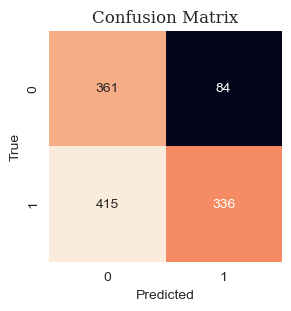

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

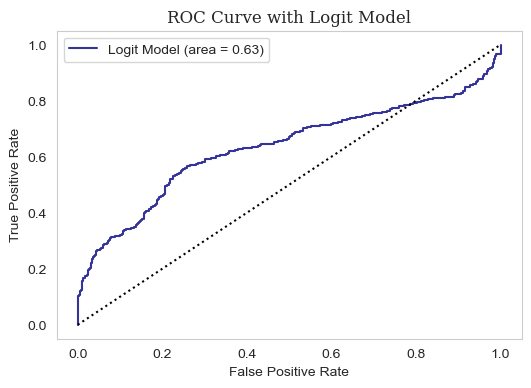

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.metrics import auc

y_pred_prob = result.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Logit Model (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.grid(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Logit Model', fontsize = 12, fontfamily = 'Serif')
plt.legend()
plt.show()

**5.2 Support Vector Machine**

Secondary Model로 SVM을 사용하고 성능을 평가하라. 여기서 kernel은 linear, C = 0.1로 지정한다

In [ ]:
from sklearn.svm import SVC

X = matrix.drop('meta_label', axis = 1)
y = matrix['meta_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

svc = SVC(kernel = 'linear',
          C = 0.1, 
          probability = True,
          random_state = 42)
svc.fit(X_train, y_train)

In [ ]:
y_prob = svc.predict_proba(X_test)[:, 1]
y_pred = svc.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

In [ ]:
y_prob = svc.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'SVM (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Support Vector Machine', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()

**5.3 Decision Tree Classification**

Secondary Model로 Decision Tree를 사용하고 성능을 평가하라. 여기서 `criterion = 'entropy'`를 지정한다

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion = 'entropy',
                              
                              random_state = 42)
tree.fit(X_train, y_train)

In [ ]:
y_prob = tree.predict_proba(X_test)[:, 1]
y_pred = tree.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

In [ ]:
y_prob = tree.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Decision Tree (area = {:.2f})'.format(roc_auc), color = 'green', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Decision Tree', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()

#### 6. 모형 성능 평가

Meta Modeling을 비롯하여 technical feature들은 많은 연구가 이뤄지고 있다. 이를 기반으로 Meta labeling을 모형화 할 때, 가장 적합한 Machinie Learning 모형은 무엇인가? 여기에서 투자를 집행하는 label이 1인 점에 주목해야 한다 (실제 투자 기회를 최대한 많이 잡아내는 것이 중요한다)

Machine Learning의 강점과 한계에는 어떤 것이 있을까?